In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import MeanShift
from sklearn.metrics import euclidean_distances
%matplotlib inline

In [61]:
data = pd.read_csv('checkins.csv', sep='|').iloc[1:-1].reset_index(drop=True)
data.columns = list(map(lambda x: x.strip(), data.columns))
data = data[['latitude', 'longitude']]
data = data.applymap(lambda x: x.strip())
data = data[~(data.latitude.apply(len) == 0)].astype(float).reset_index(drop=True)
data.info()

C:\Program Files\Anaconda3\envs\myEnv\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396634 entries, 0 to 396633
Data columns (total 2 columns):
latitude     396634 non-null float64
longitude    396634 non-null float64
dtypes: float64(2)
memory usage: 6.1 MB


In [62]:
data.head()

,latitude,longitude
0,38.895112,-77.036366
1,33.800745,-84.410520
2,45.523452,-122.676207
3,40.764462,-111.904565
4,33.448377,-112.074037


In [64]:
meanshift = MeanShift(bandwidth=0.1)

In [65]:
x_train = data.values[:100000]

In [67]:
%%time
meanshift.fit(x_train)

Wall time: 1min 55s


MeanShift(bandwidth=0.1)

In [71]:
result = np.hstack((x_train, meanshift.labels_.reshape(-1, 1)))

In [72]:
result

array([[  38.8951118,  -77.0363658,    5.       ],
       [  33.800745 ,  -84.41052  ,    7.       ],
       [  45.5234515, -122.6762071,   30.       ],
       ...,
       [  29.7628844,  -95.3830615,   25.       ],
       [  32.802955 ,  -96.769923 ,   19.       ],
       [  37.7749295, -122.4194155,    4.       ]])

In [87]:
clusters = np.unique(result[:, -1])

In [135]:
best_clusters = []
for cluster in clusters:
    if len(np.where(result[:, -1] == cluster)[0]) > 15:
        best_clusters.append(cluster)
best_clusters = np.array(best_clusters, dtype=int)

In [136]:
len(best_clusters), len(clusters)

(592, 3231)

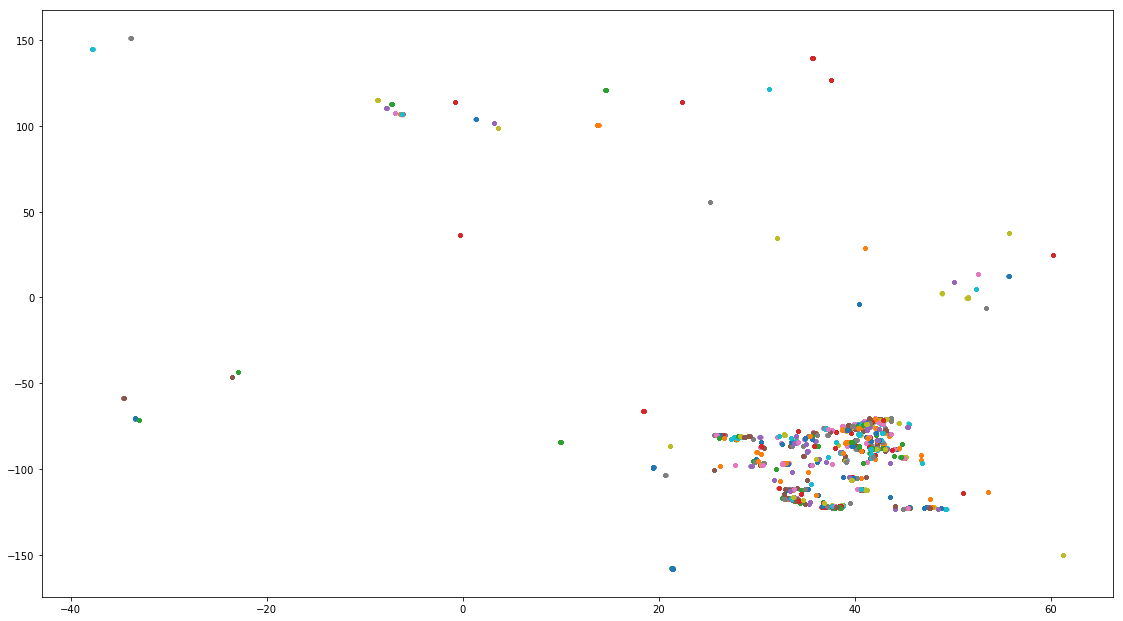

In [137]:
plt.figure(figsize=(19.20, 10.80))
for cluster in best_clusters:
    slice_idx = result[:, -1].ravel() == cluster
    subset = result[slice_idx]
    plt.scatter(subset[:, 0], subset[:, 1], s=10)

In [138]:
best_clusters_centers = meanshift.cluster_centers_[best_clusters]

In [139]:
best_clusters_centers

array([[  40.7177164 ,  -73.99183542],
       [  33.44943805, -112.00213969],
       [  33.44638027, -111.90188756],
       ...,
       [  41.61853175,  -88.44556818],
       [  39.2494686 ,  -77.1821271 ],
       [  38.65877915,  -76.8856871 ]])

In [140]:
offices = {
    'Los Angeles': np.array([33.751277, -118.188740]),
    'Miami': np.array([25.867736, -80.324116]),
    'London': np.array([51.503016, -0.075479]),
    'Amsterdam': np.array([52.378894, 4.885084]),
    'Beijing': np.array([39.366487, 117.036146]),
    'Sydney': np.array([-33.868457, 151.205134])
}

In [141]:
offices

{'Amsterdam': array([52.378894,  4.885084]),
 'Beijing': array([ 39.366487, 117.036146]),
 'London': array([51.503016, -0.075479]),
 'Los Angeles': array([  33.751277, -118.18874 ]),
 'Miami': array([ 25.867736, -80.324116]),
 'Sydney': array([-33.868457, 151.205134])}

In [147]:
for city, center in offices.items():
    center = center.reshape(1, -1)
    d = euclidean_distances(center, best_clusters_centers).ravel()
    sort_idx = np.argsort(d)[:20]
    closest_clusters = best_clusters[sort_idx]
    closest_cluster_coords = best_clusters_centers[sort_idx[0]]
    distance_to_closest_cluster = d[sort_idx][0]
    print(city)
    print(closest_clusters)
    print(closest_cluster_coords)
    print('distance', distance_to_closest_cluster)

Los Angeles
[ 51  87  42 291 119  27  11  32  17  47  64  24  35  50 100  90  75 224
 284 398]
[  33.80987796 -118.14892381]
distance 0.07084773242102914
Miami
[419  29 167  92 320  55 159 144 293 257 537 382 269 332 401 402 268 319
 124 251]
[ 25.84567226 -80.3188906 ]
distance 0.022674066135797352
London
[ 58 188 370 522 573 546 557 306 572 474 278 482 358 103 217 409 449 657
 471 249]
[51.50299126 -0.12553729]
distance 0.0500582948278314
Amsterdam
[370 188 573  58 557 306 522 546 572 474 278 482 358 103 217 409 449 657
 471 249]
[52.37296399  4.89231722]
distance 0.00935331618447212
Beijing
[432 223 538 213 383 261 210 294 369 160 333 556  33 510 211 252 156 447
 359 358]
[ 31.230393 121.473704]
distance 9.26757501076729
Sydney
[420 483 359 252 447 333 156 556 211  33 510 383 160 294 369 538 261 210
 213 432]
[-33.86063043 151.20477593]
distance 0.007834758333930724


Сидней ближайший